# CNET 5442 — Sports Analytics Through Data and Networks (Spring 2026)  
## Class 04 — Distributions, Odds, and Surprises

This notebook is the in-class companion to the Class 04 slides.

We’ll do two things in parallel:

1. Build intuition with toy simulations (so everything runs even without soccer data).
2. Apply the ideas to a real dataset: `EPL 2024 shots`.


> Big idea: a probability model is a *recipe for generating data*.  
> A distribution is the *fingerprint* that recipe leaves behind.

Course materials live here: https://github.com/jkbren/cnet5442_sp26

## Roadmap for today (and what this notebook covers)

We'll build intuition in toy simulations first, and then connect those ideas to a soccer case study.

1. **Probability basics:** random variables, PMF/PDF/CDF, expectation, variance  
2. **Core sports distributions:** Bernoulli, Binomial, Poisson, Geometric, Exponential  
3. **Surprise:** turning "unlikely" into a number (surprisal), and why log-loss shows up everywhere  
4. **Case study:** time between goals in soccer (waiting-time distributions + a minimal simulation model)  
5. **Supplemental:** a deeper odds section (decimal/american/fractional odds, implied probabilities, and bookmaker margin)

A notebook is not a textbook. The goal is to be clear, runnable, and reusable.


__________
## A quick historical aside

Modern probability theory grew out of a very practical question: how do you price uncertainty fairly?

A famous early example is the "problem of points" discussed in letters between Pascal and Fermat (1654): if a game is interrupted before someone wins, how should the stake be split?

![](images/pascal_fermat.png)

__________

A useful mental pipeline (then and now):

1. Define possible future outcomes  
2. Assign probabilities to those outcomes  
3. Compute expected values (average outcomes under the model)

> "The theory of probabilities is at bottom nothing but common sense reduced to calculus."  
> — Pierre-Simon Laplace

References:
- APS News (2009), "Pascal, Fermat and the Problem of Points": https://www.aps.org/apsnews/2009/07/pascal-letters-fermat-points
- Hacking (1975), *The Emergence of Probability*


## What you should be able to do after today

- Define events, random variables, PMF/PDF/CDF, expectation, and variance
- Explain why repeated sampling produces a stable empirical distribution
- Simulate and interpret core distributions that show up in sports:
  - Bernoulli / Binomial (successes out of attempts)
  - Poisson (event counts per interval)
  - Geometric / Exponential (waiting times)
- Compute and interpret *surprisal* $s(x)=-\log p(x)$ and *entropy* as an expected surprisal
- Evaluate probabilistic predictions with simple *scoring rules* (log loss and Brier score)
- Convert *odds ↔ implied probabilities*, and compute a bookmaker *margin (overround)* (supplemental section)



---

## Data used in the second half

This notebook expects these files if you want to run the soccer sections:

- `data/EPL_2024_shots.csv` (shot-level data for one EPL season)
- `data/shot_times_six_leagues.csv` (goal timestamps across leagues/seasons)

If you don't have those files locally, the probability + toy simulation sections still run.


## Common packages and setup that we (I) often use

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

In [2]:
# Reproducibility for random demos
rng = np.random.default_rng(5)

### Quick Python / NumPy refresher (optional)

If you're already comfortable with NumPy arrays and random number generation, feel free to skip.

Two important ideas we'll use all class:
- **Vectorization:** operate on whole arrays instead of Python loops (faster, cleaner).
- **Random generators:** set a seed once so our examples are reproducible.


In [3]:
# Arrays and vectorized operations
x = np.array([1, 2, 3, 4, 5])
x, x.mean(), x.std()

(array([1, 2, 3, 4, 5]), 3.0, 1.4142135623730951)

In [4]:
# Random numbers (Uniform[0,1])
u = rng.random(5)
u


array([0.80500292, 0.80794079, 0.51532556, 0.28580138, 0.0539307 ])

In [5]:
# Bernoulli trials (1 with prob p, else 0) using Binomial(n=1, p)
p = 0.7
trials = rng.binomial(n=1, p=p, size=20)
trials, trials.mean()


(array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]), 0.75)

In [6]:
# Boolean masking: keep only the successes
trials[trials == 1]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Probability basics

This is the minimum vocabulary we'll use whenever we say that a model assigns probabilities. In sports analytics, we often build models that answer questions like:

- What is the probability the next shot becomes a goal?
- How many goals do we expect in a match?
- How long do we expect to wait until the next goal?

To do that cleanly, we need a few core objects: events, random variables, and distributions.

### Acronyms and notation you will see

- **RV**: random variable  
- **PMF**: probability mass function (discrete)  
- **PDF**: probability density function (continuous)  
- **CDF**: cumulative distribution function (works for both)  
- **i.i.d.**: independent and identically distributed (a common assumption in toy models)  
- **EV**: expected value (another name for expectation)

Notation (standard in stats/probability):

- $P(A)$: probability of event $A$  
- $E[X]$: expectation of random variable $X$  
- $\mathrm{Var}(X)$: variance of $X$, and $\sigma_X = \sqrt{\mathrm{Var}(X)}$ is the standard deviation  
- $p(x)$ or $P(X=x)$: a PMF (discrete)  
- $f(x)$: a PDF (continuous)  
- $F(x)$: a CDF  
- $\hat p$: an estimated or implied probability (a "hat" often means estimate)



### Events and probabilities

- A **sample space** $\Omega$ contains all possible outcomes of an experiment.
- An **event** $A \subseteq \Omega$ is a set of outcomes we care about.
- A **probability** assigns a number $P(A) \in [0,1]$ to each event.

The three "axioms" behind probability (informally):

1. $P(A) \ge 0$ for any event $A$  
2. $P(\Omega) = 1$  
3. If $A$ and $B$ cannot both happen (disjoint), then $P(A \cup B) = P(A) + P(B)$

Useful constructions:

- **Complement:** $A^c$ means "not $A$", and $P(A^c) = 1 - P(A)$  
- **Conditional probability:** for $P(B) > 0$,
  $$P(A\mid B) = \frac{P(A\cap B)}{P(B)}$$
- **Independence:** $A$ and $B$ are independent if $P(A\cap B) = P(A)P(B)$

Sports examples:

- $A$ = "the home team wins"
- $B$ = "the home team scores first"  
- $P(A\mid B)$ = "win probability given scoring first"


### Random variables

A **random variable (RV)** $X$ is a function that maps outcomes to numbers.

- The randomness comes from the experiment’s outcome, not from the function itself.
- Random variables let us compute averages, spreads, and compare models numerically.

Sports examples:

- Shot outcome: $Y \in \{0,1\}$ (miss/goal)  
- Goals in a match: $G \in \{0,1,2,\dots\}$  
- Time to next goal: $T \ge 0$ (a waiting time)

### Distributions: PMF, PDF, CDF

A distribution tells you how probability is allocated over values of an RV.

- **PMF** (discrete): $p_X(x) = P(X=x)$, with $\sum_x p_X(x)=1$  
- **PDF** (continuous): $f_X(x)$, with $\int_{-\infty}^{\infty} f_X(x)\,dx = 1$  
  - probabilities come from **areas**:
    $$P(a \le X \le b) = \int_a^b f_X(x)\,dx$$
- **CDF** (both): $F_X(x) = P(X \le x)$  
  - for a discrete RV, $F_X$ is a step function  
  - for a continuous RV, $F_X$ is smooth, and if it’s differentiable then:
    $$f_X(x) = \frac{d}{dx}F_X(x)$$

### Expectation and variance

Expectation is a weighted average (a "center"), and variance is spread.

- Discrete:
  $$E[X] = \sum_x x\,P(X=x)$$
- Continuous:
  $$E[X] = \int x\,f(x)\,dx$$
- Variance:
  $$\mathrm{Var}(X) = E[(X-E[X])^2] = E[X^2] - (E[X])^2$$

Two quick interpretation tips:

- $E[X]$ has the **same units** as $X$ (goals, minutes, points).  
- $\mathrm{Var}(X)$ has **squared units**; $\sigma_X$ puts it back in the original units.

We'll mostly treat variables as **discrete** today (counts and integer minutes), because that's how the data are recorded.


### Discrete vs continuous

This is one of the easiest places to get confused, so it's worth slowing down.

#### Discrete (PMF)

A **discrete** random variable takes values in a *countable* set (like $\{0,1,2,\dots\}$).

- A **PMF** gives *actual probabilities* at points: $p_X(k) = P(X=k)$

- These probabilities add up: $\sum_k p_X(k) = 1$

A bar chart of a PMF is showing **probability at each bar**.

#### Continuous (PDF)

A **continuous** random variable can take values in an interval (like any real number between 0 and 90).

- A **PDF** is a *density*, not a probability: $f_X(x) \ge 0$
- The probability of an interval is an **area**: $P(a \le X \le b) = \int_a^b f_X(x)\,dx$
- For a truly continuous RV, the probability of an exact value is: $P(X=x)=0$

Two key implications:

- A PDF can be **greater than 1**. That is not a problem, because it is not a probability.
- A PDF has **units**. If $X$ is measured in minutes, then $f_X(x)$ has units of "per minute."

#### Histograms sit in between

When you make a histogram of continuous data, you're approximating a density by binning values.
If you divide counts by $(\text{sample size})\times(\text{bin width})$, the histogram approximates a PDF.

We'll visualize this with:
- a Bernoulli PMF (discrete)
- a Normal PDF (continuous)


In [7]:
def normal_pdf(x: np.ndarray, mu: float = 0.0, sigma: float = 1.0) -> np.ndarray:
    """Compute the Normal(μ, σ) probability density function.

    Parameters
    ----------
    x:
        Points at which to evaluate the density.
    mu:
        Mean of the normal distribution.
    sigma:
        Standard deviation of the normal distribution (must be > 0).

    Returns
    -------
    np.ndarray
        Density values f(x).
    """
    x = np.asarray(x, dtype=float)
    if sigma <= 0:
        raise ValueError("sigma must be positive.")
    coef = 1.0 / (sigma * np.sqrt(2 * np.pi))
    return coef * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


In [8]:
# Discrete: Bernoulli(p)
p = 0.3
bernoulli_x = np.array([0, 1])
bernoulli_pmf = np.array([1 - p, p])

# Continuous: Normal(0,1)
xx = np.linspace(-4, 4, 400)
yy = normal_pdf(xx)

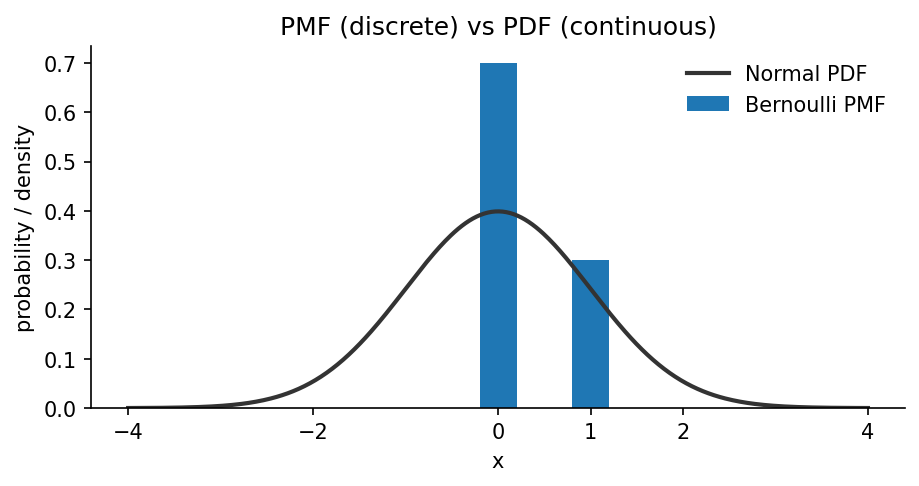

In [9]:
fig, ax = plt.subplots(figsize=(7, 3.2), dpi=150)

ax.bar(bernoulli_x, bernoulli_pmf, width=0.4, label="Bernoulli PMF")
ax.plot(xx, yy, lw=2, label="Normal PDF", color='.2')

ax.set_xlabel("x")
ax.set_ylabel("probability / density")
ax.set_title("PMF (discrete) vs PDF (continuous)")
ax.set_xticks([-4, -2, 0, 1, 2, 4])
ax.legend(framealpha=0.0)
ax.spines[["right", "top"]].set_visible(False)

plt.show()

---

## From repeated samples to a distribution

Let’s build the simplest example:

- One coin flip is a **Bernoulli** random variable.
- The number of heads in $n$ flips is **Binomial**.
- If we repeat "$n$ flips" many times, the histogram stabilizes.

This is the practical meaning of a *distribution*:  
it’s what you see when you repeat the same random recipe over and over.


In [10]:
def binom_pmf(k, n, p):
    """Evaluate the Binomial(n, p) PMF at integer k values.

    The Binomial model describes the number of successes in n independent
    Bernoulli(p) trials.

    PMF:
        P(K = k) = C(n, k) p^k (1-p)^(n-k)  for k = 0, 1, ..., n

    Parameters
    ----------
    k:
        Integer support values where the PMF should be evaluated.
    n:
        Number of trials (must be >= 0).
    p:
        Success probability (must be in [0, 1]).

    Returns
    -------
    np.ndarray
        PMF values aligned with k.
    """
    if n < 0:
        raise ValueError("n must be nonnegative.")
    if not (0.0 <= p <= 1.0):
        raise ValueError("p must be in [0, 1].")

    k = np.asarray(k, dtype=int)
    pmf = np.zeros_like(k, dtype=float)

    for i, ki in enumerate(k):
        if 0 <= ki <= n:
            pmf[i] = math.comb(n, int(ki)) * (p ** int(ki)) * ((1 - p) ** (n - int(ki)))
    return pmf


In [11]:
# Repeated sampling: number of heads in n flips
n = 10
p = 0.5
N = 10_000  # number of repeated experiments (each experiment = n flips)

heads = rng.binomial(n=n, p=p, size=N)  # number of heads in each experiment
heads[:10], heads.mean(), heads.var()

(array([7, 4, 7, 7, 2, 6, 1, 5, 5, 4]), 4.9846, 2.51916284)

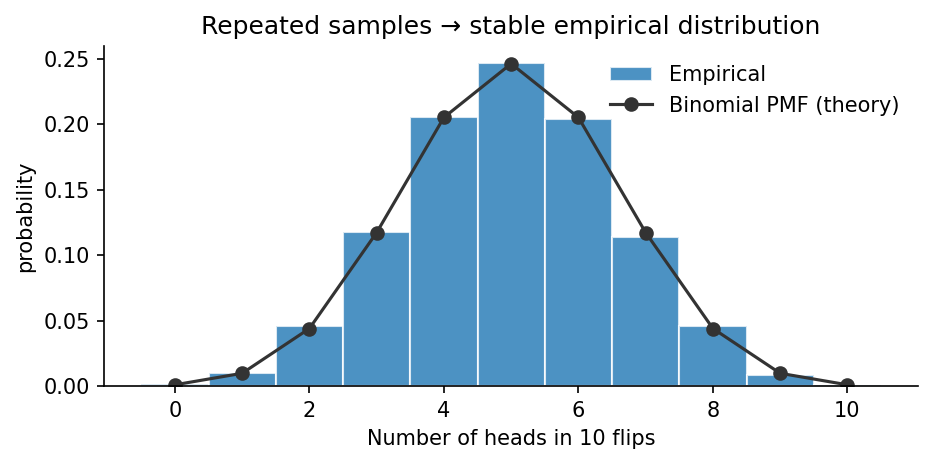

In [12]:
import math
# Empirical distribution (histogram) vs theoretical Binomial PMF
k = np.arange(0, n + 1)
pmf = binom_pmf(k, n=n, p=p)

fig, ax = plt.subplots(figsize=(7, 3), dpi=150)

ax.hist(heads, bins=np.arange(-0.5, n + 1.5, 1), density=True, alpha=0.8, edgecolor="white", label="Empirical")
ax.plot(k, pmf, marker="o", lw=1.5, label="Binomial PMF (theory)", color='.2')

ax.set_xlabel(f"Number of heads in {n} flips")
ax.set_ylabel("probability")
ax.set_title("Repeated samples → stable empirical distribution")
ax.legend(framealpha=0.0)
ax.spines[["right", "top"]].set_visible(False)

plt.show()

### Try it

- Change `p` to `0.6` or `0.8`. What happens to the center and the spread?
- Change `n` to `20`. Does the shape look "more normal"?
- Change `N` from `1_000` to `100_000`. What changes, and what stays the same?


---

## Law of Large Numbers (LLN): what you see in practice

If $X_1, X_2, \dots$ are i.i.d. with mean $\mu$, the sample mean

$$
\bar X_n = \frac{1}{n}\sum_{i=1}^n X_i
$$

gets closer to $\mu$ as $n$ grows.

**Translation:** averages become stable, even when individual outcomes stay random.


In [13]:
# LLN in one picture: running average of Bernoulli trials
p_true = 0.3
N = 5_000

x = rng.binomial(n=1, p=p_true, size=N)
running_mean = np.cumsum(x) / np.arange(1, N+1)

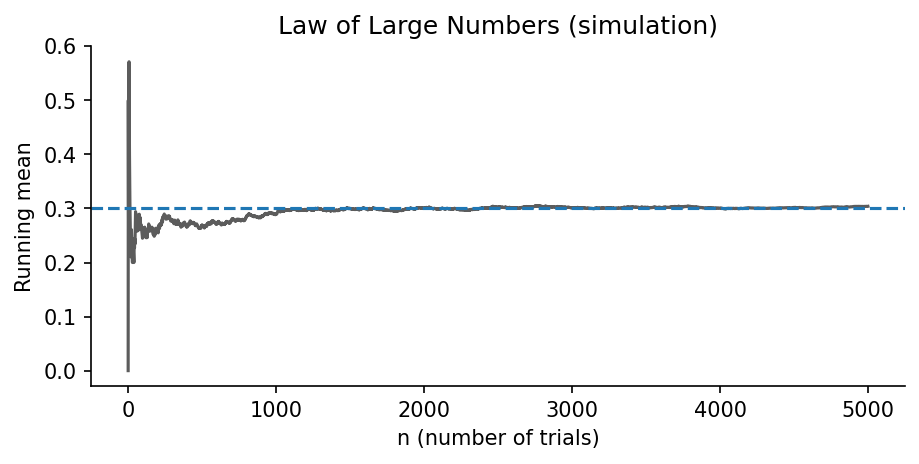

In [14]:
fig, ax = plt.subplots(figsize=(7,3), dpi=150)

ax.plot(running_mean, c='.2', alpha=0.8)
ax.axhline(p_true, linestyle='--')
ax.set_xlabel('n (number of trials)')
ax.set_ylabel('Running mean')
ax.set_title('Law of Large Numbers (simulation)')
ax.spines[['right','top']].set_visible(False)


plt.show()

A second perspective: if we repeat the *same* experiment many times, the distribution of sample means gets tighter around the true mean as $n$ grows.


In [15]:
# Distribution of sample means shrinks as n grows
p_true = 0.3
M = 8_000  # number of repeated experiments
ns = [10, 50, 200, 1000]

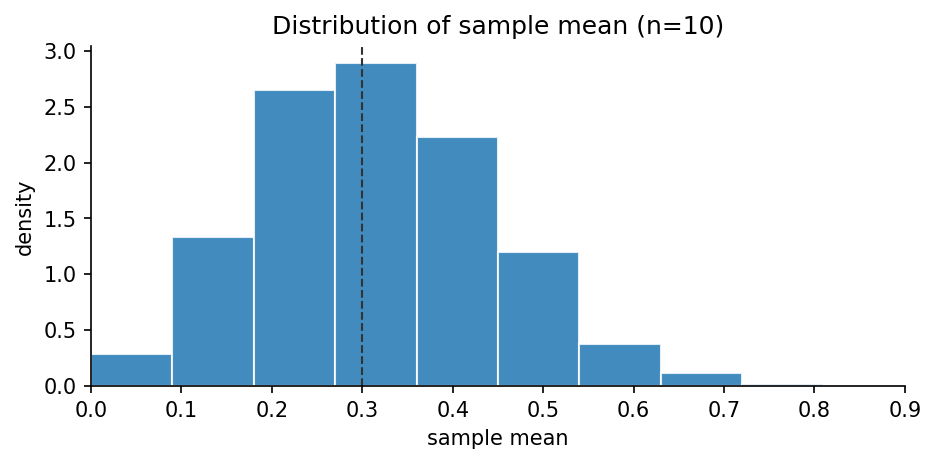

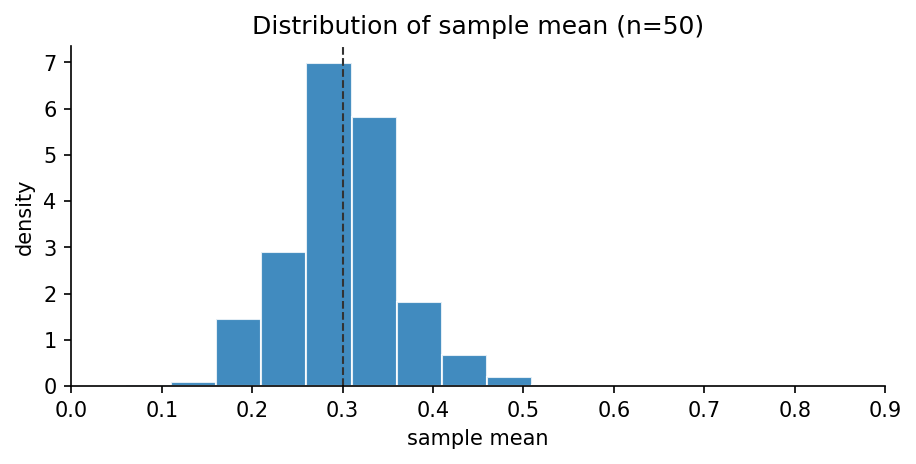

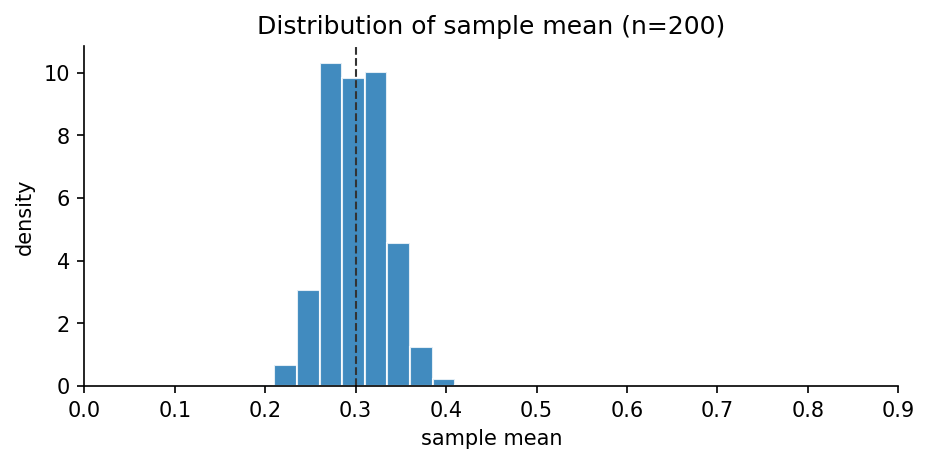

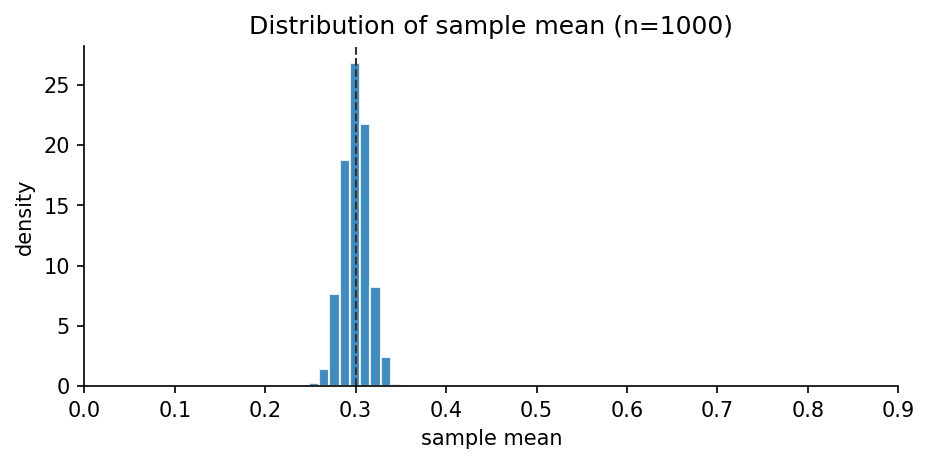

In [16]:
for n in ns:
    means = rng.binomial(n=1, p=p_true, size=(M, n)).mean(axis=1)

    fig, ax = plt.subplots(figsize=(7, 3), dpi=150)

    ax.hist(means, bins=10, density=True, alpha=0.85, edgecolor="white")
    ax.axvline(p_true, linestyle="--", linewidth=1, color='.2')

    ax.set_title(f"Distribution of sample mean (n={n})")
    ax.set_xlabel("sample mean")
    ax.set_ylabel("density")
    ax.set_xlim(0, 0.9)
    ax.spines[["right", "top"]].set_visible(False)

    plt.show()


---

## Core distributions that show up in sports

The distributions below are starter models for the kinds we often see in sports analytics. They won't capture everything (teams differ, game state matters, events aren't fully independent), but they're useful baselines.

### Bernoulli (one attempt)
- Support: $\{0,1\}$  
- Parameter: $p$  
- Example: a free throw, penalty kick, or shot (goal vs no goal)

### Binomial (successes in $n$ attempts)
If $K$ is the number of successes in $n$ Bernoulli trials:

$$
K \sim \mathrm{Binomial}(n,p), \qquad E[K]=np, \quad \mathrm{Var}(K)=np(1-p)
$$

### Poisson (events in a window)
If events happen at an average rate $\lambda$ per unit time, then the number of events in a time window of length $T$ satisfies:

$$
N(T) \sim \mathrm{Poisson}(\lambda T), \qquad E[N(T)] = \lambda T
$$

### Geometric (waiting time in discrete time)
If each minute is an independent Bernoulli($p$) chance of a goal:

$$
W \sim \mathrm{Geometric}(p), \qquad P(W=k)=(1-p)^{k-1}p, \; k=1,2,\dots
$$

### Exponential (waiting time in continuous time)
Continuous-time analogue with constant rate $\lambda$:

$$
T \sim \mathrm{Exponential}(\lambda), \qquad f(t)=\lambda e^{-\lambda t}, \; t\ge 0
$$


In [17]:
def poisson_pmf(k, lam):
    """Evaluate the Poisson(λ) PMF at integer k values.

    PMF:
        P(K = k) = e^{-λ} λ^k / k!   for k = 0, 1, 2, ...

    Parameters
    ----------
    k:
        Integer support values where the PMF should be evaluated.
    lam:
        Rate parameter λ (must be >= 0).

    Returns
    -------
    np.ndarray
        PMF values aligned with k.
    """
    if lam < 0:
        raise ValueError("lam must be nonnegative.")

    k = np.asarray(k, dtype=int)
    pmf = np.zeros_like(k, dtype=float)

    for i, ki in enumerate(k):
        if ki >= 0:
            pmf[i] = (lam ** int(ki)) * np.exp(-lam) / math.factorial(int(ki))
    return pmf


def geometric_pmf(k, p):
    """
    Evaluate the Geometric(p) PMF on k=1,2,3,... (trials until first success).

    PMF:
        P(W = k) = (1-p)^(k-1) p   for k = 1, 2, ...

    Parameters
    ----------
    k:
        Integer support values (should start at 1).
    p:
        Success probability (must be in (0, 1]).

    Returns
    -------
    np.ndarray
        PMF values aligned with k.
    """
    if not (0.0 < p <= 1.0):
        raise ValueError("p must be in (0, 1].")

    k = np.asarray(k, dtype=int)
    pmf = np.zeros_like(k, dtype=float)

    for i, ki in enumerate(k):
        if ki >= 1:
            pmf[i] = ((1 - p) ** (int(ki) - 1)) * p
    return pmf


### Example: Binomial as a toy free-throw model

Suppose a player makes free throws with probability $p=0.75$.
If they take $n=10$ free throws, the number made is $\mathrm{Binomial}(n,p)$.


In [18]:
p = 0.75   # free throw % (toy)
n = 10      # attempts

k = np.arange(0, n + 1)
pmf = binom_pmf(k, n=n, p=p)

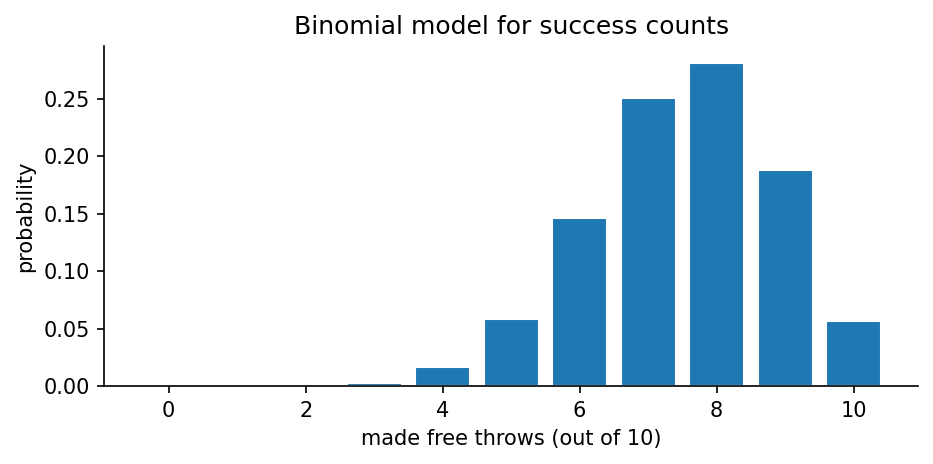

P(miss all 10) = 9.5367431640625e-07
P(make at least 8) = 0.5255928039550781


In [19]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.bar(k, pmf, edgecolor="white")
ax.set_xlabel("made free throws (out of 10)")
ax.set_ylabel("probability")
ax.set_title("Binomial model for success counts")
ax.spines[["right", "top"]].set_visible(False)
plt.show()

print("P(miss all 10) =", (1 - p) ** n)
print("P(make at least 8) =", pmf[k >= 8].sum())


### Example: Poisson as a baseline goals-per-match model

A classic first model is: goals scored in a match are Poisson with mean $\lambda$.

This is *not* a perfect model (teams differ, match context matters), but it's a useful baseline.


In [20]:
lam = 2.6  # average goals per match (toy)
k = np.arange(0, 9)
pmf = poisson_pmf(k, lam=lam)

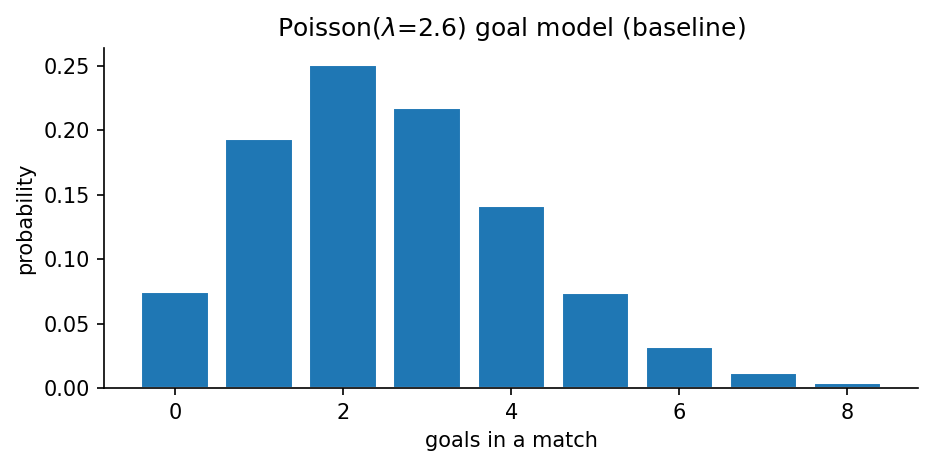

P(0 goals) under Poisson = 0.07427357821433388


In [21]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.bar(k, pmf, edgecolor="white")
ax.set_xlabel("goals in a match")
ax.set_ylabel("probability")
ax.set_title(f"Poisson($\lambda$={lam}) goal model (baseline)")
ax.spines[["right", "top"]].set_visible(False)
plt.show()

print("P(0 goals) under Poisson =", pmf[0])


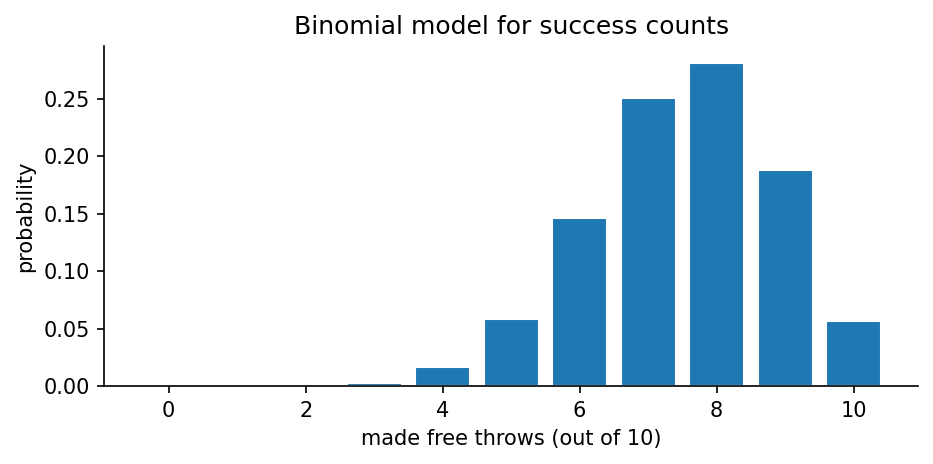

P(miss all 10) = 9.5367431640625e-07
P(make at least 8) = 0.5255928039550781


In [22]:
# Binomial example: free throws
p = 0.75   # free throw % (toy)
n = 10     # attempts

k = np.arange(0, n+1)
pmf = binom_pmf(k, n=n, p=p)

fig, ax = plt.subplots(figsize=(7,3), dpi=150)
ax.bar(k, pmf, edgecolor='white')
ax.set_xlabel('made free throws (out of 10)')
ax.set_ylabel('probability')
ax.set_title('Binomial model for success counts')
ax.spines[['right','top']].set_visible(False)
plt.show()

print("P(miss all 10) =", (1-p)**n)
print("P(make at least 8) =", pmf[k>=8].sum())


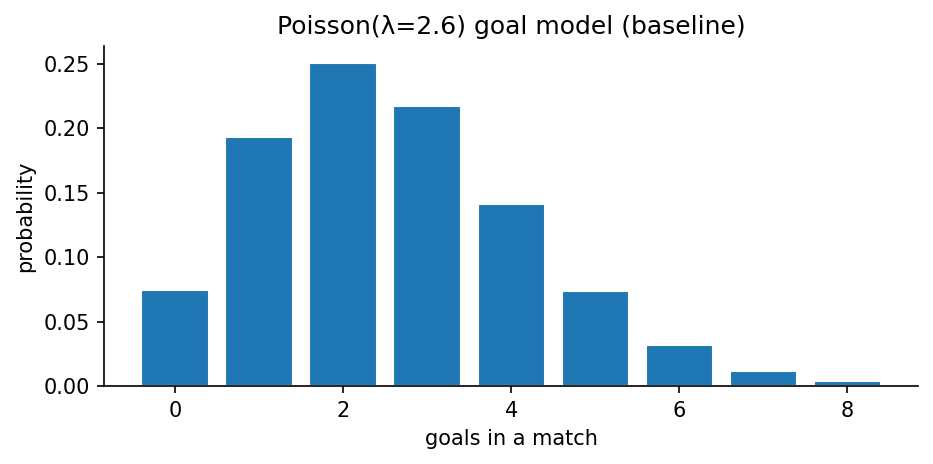

P(0-0) under Poisson = 0.07427357821433388


In [23]:
# Poisson example (toy): goals per match baseline
lam = 2.6  # average goals per match (toy)
k = np.arange(0, 9)
pmf = poisson_pmf(k, lam=lam)

fig, ax = plt.subplots(figsize=(7,3), dpi=150)
ax.bar(k, pmf, edgecolor='white')
ax.set_xlabel('goals in a match')
ax.set_ylabel('probability')
ax.set_title(f'Poisson(λ={lam}) goal model (baseline)')
ax.spines[['right','top']].set_visible(False)
plt.show()

print("P(0-0) under Poisson =", pmf[0])

### Binomial → Poisson approximation (rare events)

When $n$ is large and $p$ is small, a Binomial($n,p$) can be well-approximated by a Poisson($\lambda$) with $\lambda = np$.

This shows up whenever you're counting rare events across many opportunities.


In [24]:
n = 200
p = 0.02
lam = n * p

k = np.arange(0, 16)
pmf_bin = binom_pmf(k, n=n, p=p)
pmf_poi = poisson_pmf(k, lam=lam)

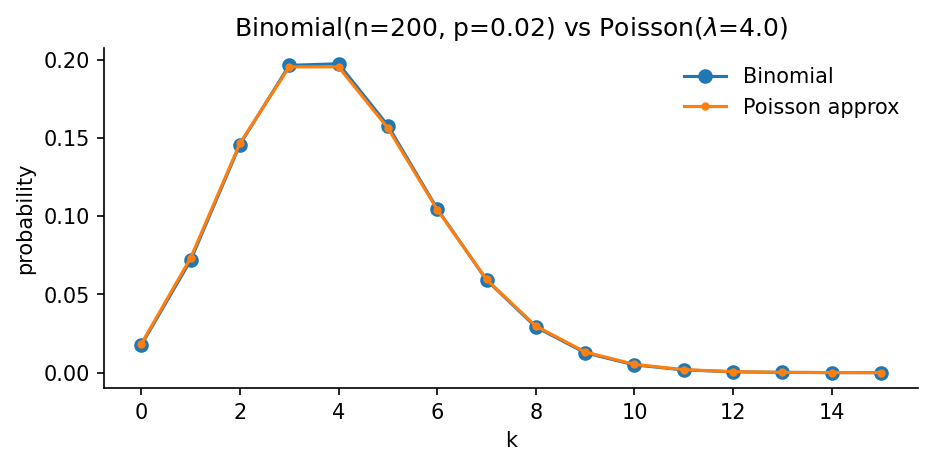

In [25]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)

ax.plot(k, pmf_bin, marker="o", lw=1.5, label="Binomial")
ax.plot(k, pmf_poi, marker=".", lw=1.5, label="Poisson approx")

ax.set_xlabel("k")
ax.set_ylabel("probability")
ax.set_title(f"Binomial(n={n}, p={p}) vs Poisson($\lambda$={lam:.1f})")
ax.legend(framealpha=0.0)
ax.spines[["right", "top"]].set_visible(False)

plt.show()

________
### Waiting times: Geometric vs Exponential

- Geometric: discrete waiting times (1,2,3,...) when time is measured in steps (minutes)
- Exponential: continuous waiting times when time is continuous

For small $p$, the geometric distribution looks similar to an exponential distribution with $\lambda \approx p$ per time step.


In [26]:
p = 0.03               # goal probability per minute (toy)
lam = p                  # for small p, geometric ~ exponential with λ ≈ p per minute
N = 20_000

geo_wait = rng.geometric(p=p, size=N)          # 1, 2, 3, ...
exp_wait = rng.exponential(scale=1 / lam, size=N)

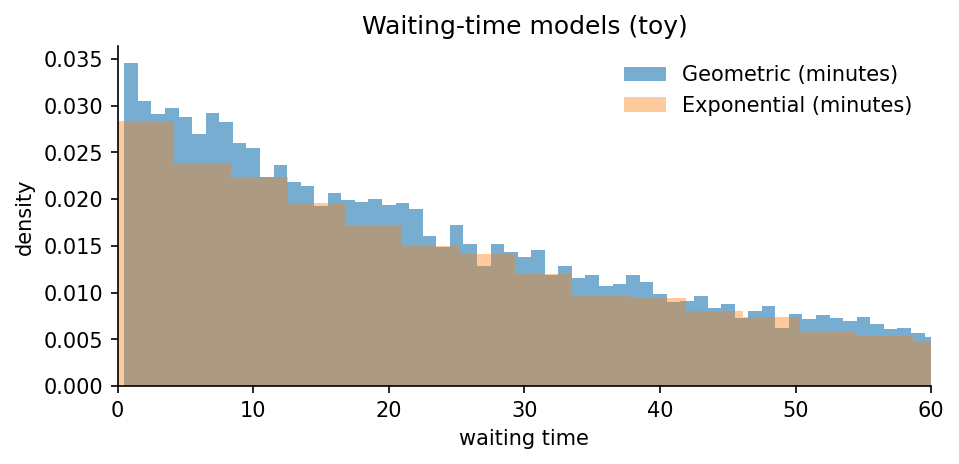

In [27]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.hist(geo_wait, bins=np.arange(0.5, 80.5, 1), density=True, alpha=0.6, label="Geometric (minutes)")
ax.hist(exp_wait, bins=80, density=True, alpha=0.4, label="Exponential (minutes)")
ax.set_xlim(0, 60)
ax.set_xlabel("waiting time")
ax.set_ylabel("density")
ax.set_title("Waiting-time models (toy)")
ax.legend(framealpha=0.0)
ax.spines[["right", "top"]].set_visible(False)
plt.show()


### Memorylessness (a signature property)

Both geometric and exponential are *memoryless*.

For a geometric waiting time $W$:

$$
P(W > s+t \mid W > s) = P(W > t).
$$

Interpretation: if we've already waited $s$ minutes with no goal, the remaining waiting time has the same distribution as if we were at kickoff (under this model).


____________

---

## Surprise: how "unlikely" becomes a number

When we say an outcome is "surprising," we usually mean:

- it had **low probability** under our model, or
- we didn’t "mentally budget" for it.

Information theory makes that intuition precise by turning probability into a **number of information units**.

### Acronyms and related terms

- **Self-information / surprisal:** the surprise of a single event  
- **Entropy:** the *average* surprise of a random variable  
- **Log loss**: a prediction loss built from surprisal  
- **NLL**: negative log-likelihood (same idea as log loss, in a statistical modeling context)  
- **KL divergence**: a measure of "how far" one distribution is from another

You do not need KL divergence for today, but it explains why log loss is such a big deal in ML and forecasting.


### Surprisal (self-information)

If an event has probability $p$, define its **surprisal**:

$$
s(p) = -\log_b(p)
$$

Interpretation:

- If $p$ is small, $s(p)$ is large (more surprising).
- If $p=1$, then $s(p)=0$ (not surprising at all).

The log base $b$ sets the units:

- base 2 → **bits**
- base $e$ → **nats** (common in statistics/ML because calculus is cleaner)

Concrete examples (base 2):

- $p=1/2 \Rightarrow s=1$ bit  
- $p=1/4 \Rightarrow s=2$ bits  
- every time you cut probability by a factor of 2, surprisal increases by 1 bit

Why use a log at all?

- Probabilities of independent events multiply:
  $$P(A\cap B) = P(A)P(B)$$
- Taking logs turns products into sums:
  $$-\log(P(A\cap B)) = -\log P(A) - \log P(B)$$

So "independent pieces of evidence" have surprises that **add**.


### Entropy

For a discrete random variable $X$ with PMF $p(x)$, the Shannon entropy is the *expected* surprisal:

$$
H(X) = E[s(p(X))] = -\sum_x p(x) \log_b p(x)
$$

Interpretation:

- Entropy measures unpredictability: **higher entropy means harder to guess correctly**.
- Entropy is maximized when outcomes are "spread out" (e.g., nearly uniform).
- For a Bernoulli($p$), entropy is highest at $p=0.5$ and goes to 0 as $p\to 0$ or $p\to 1$.

### From surprise to model evaluation: log loss

Suppose your model predicts a probability distribution $q$ and the realized outcome is $y$.
- For a multi-class outcome, **log loss** is: $\ell = -\log q(y)$

For a binary outcome $Y\in\{0,1\}$, if you predict $q=P(Y=1)$, then the same idea becomes:

$$
\ell = -\big(Y\log q + (1-Y)\log(1-q)\big)
$$

Why this matters:

- Minimizing average log loss is the same as maximizing likelihood (MLE thinking).  
- Log loss is a **proper scoring rule**: it rewards honest, calibrated probabilities.  
- It heavily punishes being **confident and wrong** (because $-\log(q)$ blows up as $q\to 0$).

Below we’ll visualize entropy for Bernoulli($p$) and compare Brier score vs log loss on a toy simulation.


In [28]:
def surprisal(p, base):
    """Compute surprisal (self-information) -log_b(p).

    Parameters
    ----------
    p:
        Probability or array of probabilities. Must satisfy 0 < p <= 1.
    base:
        Log base (2 for bits, math.e for nats).

    Returns
    -------
    float or np.ndarray
        Surprisal values in units determined by `base`.
    """
    p = np.asarray(p, dtype=float)
    if np.any(p <= 0) or np.any(p > 1):
        raise ValueError("Probabilities must satisfy 0 < p <= 1.")
    return -np.log(p) / np.log(base)


def entropy(pmf, base=2.0):
    """Compute Shannon entropy of a discrete distribution.

    Parameters
    ----------
    pmf:
        Iterable of probabilities that should sum to 1 (within numerical tolerance).
    base:
        Log base (2 for bits, math.e for nats).

    Returns
    -------
    float
        Entropy H(X) in units determined by `base`.
    """
    pmf = np.asarray(pmf, dtype=float)
    if np.any(pmf < 0):
        raise ValueError("PMF entries must be nonnegative.")
    s = pmf.sum()
    if not np.isclose(s, 1.0):
        raise ValueError(f"PMF must sum to 1. Got sum={s}.")
    pmf = pmf[pmf > 0]  # convention: 0 * log(0) = 0
    return float(-(pmf * (np.log(pmf) / np.log(base))).sum())


# Example: surprisal for a few probabilities
ps = np.array([0.5, 0.2, 0.1, 0.01])
pd.DataFrame({"p": ps, "surprisal_bits": surprisal(ps, base=2)})


,p,surprisal_bits
0,0.50,1.000000
1,0.20,2.321928
2,0.10,3.321928
3,0.01,6.643856


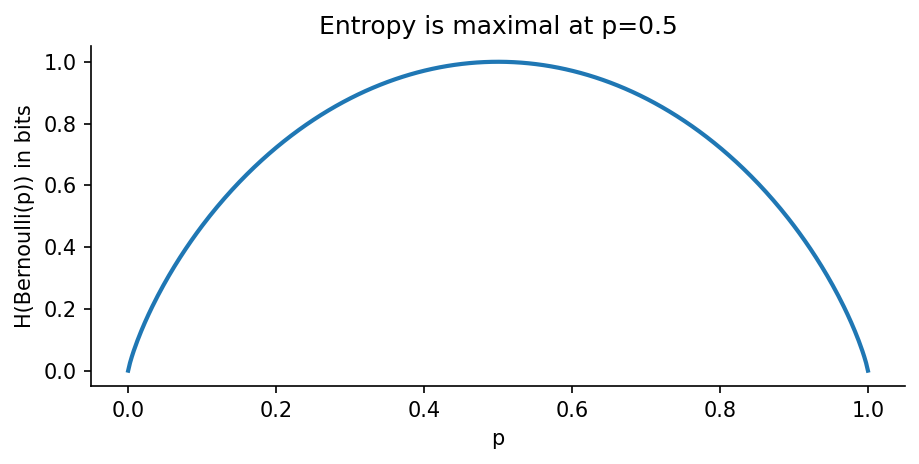

In [29]:
# Entropy of a Bernoulli(p) variable as a function of p
ps = np.linspace(1e-6, 1 - 1e-6, 400)
H = -(ps * np.log2(ps) + (1 - ps) * np.log2(1 - ps))

fig, ax = plt.subplots(figsize=(7, 3), dpi=150)

ax.plot(ps, H, lw=2)
ax.set_xlabel("p")
ax.set_ylabel("H(Bernoulli(p)) in bits")
ax.set_title("Entropy is maximal at p=0.5")
ax.spines[["right", "top"]].set_visible(False)

plt.show()

### Scoring rules: evaluating probabilistic predictions

A scoring rule takes:

- a predicted probability (or distribution), and
- the realized outcome

and returns a numerical penalty (lower is better).

This is how we evaluate models that output probabilities instead of hard 0/1 predictions.

#### Binary setup

Let $Y\in\{0,1\}$ be the observed outcome, and let $q$ be our predicted probability that $Y=1$.

Two common scoring rules:

- **Brier score:** $(q - Y)^2$  
  - interpretable as squared error on probability
- **Log loss** (a.k.a. **cross-entropy loss** in ML): $-\big(Y\log q + (1-Y)\log(1-q)\big)$

Both are proper scoring rules (informally: they encourage honest probabilities), but they behave differently:

- Brier score is more forgiving near 0 and 1.
- Log loss strongly penalizes overconfident wrong predictions.

Practical note: in code, we typically clip $q$ away from 0 and 1 (e.g., $q\in[10^{-12},1-10^{-12}]$) to avoid taking $\log(0)$.

We'll compare them on a small toy simulation below.

In [30]:
def brier_score(y_true, y_prob):
    """Mean Brier score for binary outcomes.

    Parameters
    ----------
    y_true:
        Array of 0/1 outcomes.
    y_prob:
        Array of predicted probabilities in [0, 1].

    Returns
    -------
    float
        Mean squared error between probabilities and outcomes.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_prob = np.asarray(y_prob, dtype=float)
    if np.any((y_prob < 0) | (y_prob > 1)):
        raise ValueError("y_prob must be in [0, 1].")
    return float(np.mean((y_prob - y_true) ** 2))


def log_loss(y_true, y_prob, eps=1e-15):
    """Mean log loss (negative log-likelihood) for binary outcomes.

    Uses clipping to avoid log(0).

    Parameters
    ----------
    y_true:
        Array of 0/1 outcomes.
    y_prob:
        Array of predicted probabilities in [0, 1].
    eps:
        Clipping constant to avoid log(0).

    Returns
    -------
    float
        Mean log loss.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_prob = np.asarray(y_prob, dtype=float)
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return float(-np.mean(y_true * np.log(y_prob) +\
                          (1 - y_true) * np.log(1 - y_prob)))


In [31]:
# Toy comparison: two forecasters
n = 5000
p_true = 0.3
y = rng.binomial(n=1, p=p_true, size=n)

# Forecaster A: calibrated (always predicts the true p)
q_calibrated = np.full(n, p_true)

# Forecaster B: overconfident (pushes probabilities away from 0.5)
q_over = np.where(q_calibrated >= 0.5, 0.9, 0.1)  # here p_true=0.3 -> always 0.1

print("Brier score (calibrated):", round(brier_score(y, q_calibrated), 4))
print("Brier score (overconf.) :", round(brier_score(y, q_over), 4))
print("Log loss (calibrated)  :", round(log_loss(y, q_calibrated), 4))
print("Log loss (overconf.)   :", round(log_loss(y, q_over), 4))


Brier score (calibrated): 0.2081
Brier score (overconf.) : 0.2462
Log loss (calibrated)  : 0.6068
Log loss (overconf.)   : 0.754


__________
## Data: Shots from the English Premier League in 2024-2025

We'll use an EPL 2024 shot-level dataset with (at least) these columns:

- `match_id`, `date`, `home_team`, `away_team`
- `minute` (shot minute; includes stoppage time when available)
- `result` (e.g., MissedShots, SavedShot, BlockedShot, Goal, OwnGoal, ...)
- `h_a` (home/away indicator for the shooting team)
- `xG` (expected goals for the shot)

We’ll start with a single match visualization, then aggregate across the season.


In [32]:
df = pd.read_csv('data/EPL_2024_shots.csv')
print(df.shape)

(9878, 22)


In [33]:
df.head()

,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
0,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584627,7,MissedShots,Adama Traoré,900,Rodrigo Muniz,OpenPlay,RightFoot,Pass,0.867,0.278,0.036473
1,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584628,12,SavedShot,Kenny Tete,5973,Andreas Pereira,OpenPlay,RightFoot,Pass,0.727,0.501,0.021440
2,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,a,Fulham,584629,13,BlockedShot,Rodrigo Muniz,10717,Andreas Pereira,FromCorner,Head,Cross,0.889,0.456,0.037385
3,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,h,Manchester United,584630,19,MissedShots,Bruno Fernandes,1228,Lisandro Martínez,OpenPlay,LeftFoot,Chipped,0.971,0.673,0.050078
4,EPL,2024,26602,2024-08-16 19:00:00,Manchester United,Fulham,1,0,h,Manchester United,584631,26,MissedShots,Casemiro,2248,Mason Mount,OpenPlay,RightFoot,Pass,0.747,0.479,0.020807


__________

## Case Study: December 22, 2024

We'll use Bournemouth’s 3–0 win at Old Trafford on December 22, 2024 as our running (very unbiased) example. It's an ideal example to look at our hands-on study of goal-scoring dynamics: three goals, lots of shots, etc.

![](images/bournemouth_united.jpg)
**Image from:** ESPN. (2024, December 22). Man United 0, Bournemouth 3: Premier League match report. ESPN. https://www.espn.com/soccer/report/_/gameId/704440.


The analysis idea:
1. Visualize shots/goals on a timeline  
2. Extract goal times  
3. Turn goal times into **between-goal waiting times** $\Delta$  
4. Repeat over many matches → empirical waiting-time distribution



In [34]:
game_id = 26769
df_mun_bou = df.loc[df['match_id']==game_id].copy()
print(df_mun_bou.shape)
df_mun_bou.head()

(33, 22)


,league,season,match_id,date,home_team,away_team,home_goals,away_goals,h_a,team,shot_id,minute,result,player,player_id,player_assisted,situation,shotType,lastAction,X,Y,xG
4436,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608693,5,SavedShot,Amad Diallo Traore,8127,NaN,OpenPlay,LeftFoot,NaN,0.870,0.519,0.082709
4437,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608694,8,SavedShot,Antoine Semenyo,11363,Ryan Christie,OpenPlay,LeftFoot,Pass,0.792,0.516,0.042886
4438,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,h,Manchester United,608695,17,SavedShot,Bruno Fernandes,1228,Amad Diallo Traore,OpenPlay,RightFoot,Pass,0.721,0.708,0.011621
4439,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608696,23,MissedShots,Justin Kluivert,6963,Dean Huijsen,OpenPlay,RightFoot,Pass,0.769,0.439,0.027950
4440,EPL,2024,26769,2024-12-22 14:00:00,Manchester United,Bournemouth,0,3,a,Bournemouth,608697,27,BlockedShot,Antoine Semenyo,11363,Ryan Christie,OpenPlay,RightFoot,Pass,0.778,0.687,0.023058


In [35]:
shot_times = df_mun_bou['minute'].values

### Visual: a match as a timeline of events

A "rug plot" is a simple way to show **when** shots (and goals) happen.


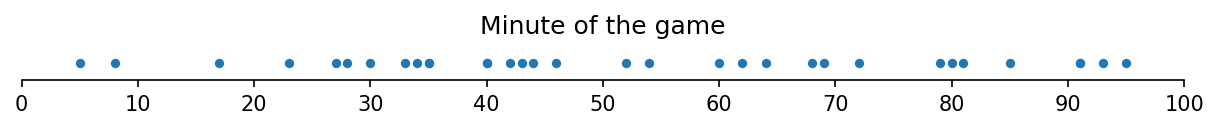

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,0.3),dpi=150)

ax.scatter(shot_times, [0]*len(shot_times), lw=0, s=20)


ax.set_yticks([])
ax.set_xticks(range(0,110,10))
ax.set_title('Minute of the game')
ax.spines[['right', 'top', 'left']].set_visible(False)



plt.show()

Can we separate by team?

In [37]:
h_or_a_team = df_mun_bou['h_a'].values

bournemouth_shots = [shot_times[i] for i,ha in enumerate(h_or_a_team) if ha=='a']
manc_united_shots = [shot_times[i] for i,ha in enumerate(h_or_a_team) if ha=='h']

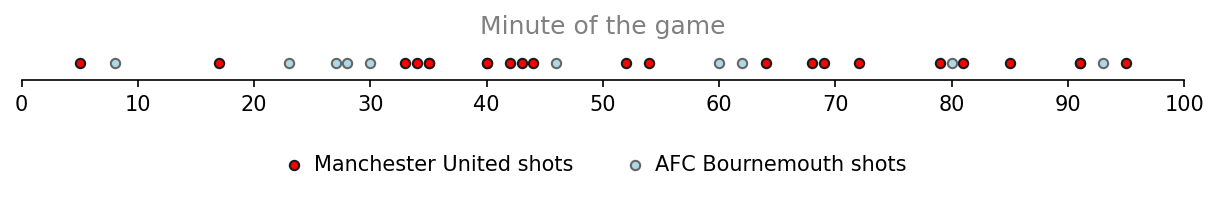

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,0.3),dpi=150)


# ax.scatter(shot_times, [0]*len(shot_times), lw=0, s=20)
ax.scatter(manc_united_shots, [0]*len(manc_united_shots), ec='.1', s=20,
           label='Manchester United shots', color='red')
ax.scatter(bournemouth_shots, [0]*len(bournemouth_shots), ec='.4', s=20,
           label='AFC Bournemouth shots', color='lightblue')


ax.legend(ncol=3,loc=2,bbox_to_anchor=[0.2, -1.65],framealpha=0.0,handletextpad=-0.05)


ax.set_yticks([])
ax.set_xticks(range(0,110,10))
ax.set_title('Minute of the game',color='.5')
ax.spines[['right', 'top', 'left']].set_visible(False)



plt.show()

_____________

What about goals?

In [39]:
goal_times = df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]['minute'].values

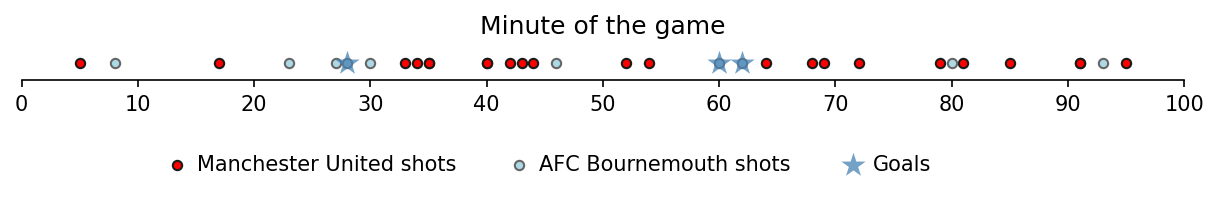

In [40]:
fig, ax = plt.subplots(1,1,figsize=(10,0.3),dpi=150)


# ax.scatter(shot_times, [0]*len(shot_times), lw=0, s=20)
ax.scatter(manc_united_shots, [0]*len(manc_united_shots), ec='.1', s=20,
           label='Manchester United shots', color='red')
ax.scatter(bournemouth_shots, [0]*len(bournemouth_shots), ec='.4', s=20,
           label='AFC Bournemouth shots', color='lightblue')

ax.scatter(goal_times, [0.0]*len(goal_times), lw=0, s=150, label='Goals',
           color='steelblue', marker='*', alpha=0.75)


ax.legend(ncol=3,loc=2,bbox_to_anchor=[0.1, -1.65],framealpha=0.0,handletextpad=-0.05)


ax.set_yticks([])
ax.set_xticks(range(0,110,10))
ax.set_title('Minute of the game')
ax.spines[['right', 'top', 'left']].set_visible(False)



plt.show()

_________

## How to get time between goals?
Recall from the slides, we want this value?

![](images/slides.png)

### Time between goals (within a match)

For a match with goal minutes $t_1 < t_2 < \dots < t_m$, the between-goal times are:

$$
\Delta_i = t_i - t_{i-1}.
$$

(We’ll compute these and then aggregate across matches.)


In [41]:
df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]['minute'].diff()

4441     NaN
4455    32.0
4456     2.0
Name: minute, dtype: float64

In [42]:
df_mun_bou.loc[df_mun_bou['result'].isin(['Goal','OwnGoal'])]['minute'].diff().dropna().values.astype(int).tolist()

[32, 2]

## Your turn: Get the inter-goal time for every match in the season

In [43]:
# filter to matches with 2+ goals (match-level columns are repeated on each shot row)
df_goals_2plus = df.loc[(df['home_goals'] + df['away_goals'] >= 2)].copy()
df_goals_2plus = df_goals_2plus.loc[df_goals_2plus['result'].isin(['Goal','OwnGoal'])].copy()


In [44]:
# sort so diff means "time between consecutive goals"
df_goals_2plus = df_goals_2plus.sort_values(['match_id', 'minute'])


In [45]:
# time between consecutive goals within each match
df_goals_2plus['timediff'] = df_goals_2plus.groupby('match_id')['minute'].diff()


In [46]:
# keep only actual between-goal intervals
goaltimes_df = df_goals_2plus.loc[df_goals_2plus['timediff'].notna()].copy()


In [47]:
# clean up: integers, drop zero/negative (can happen if same-minute logging)
goaltimes_df['timediff'] = goaltimes_df['timediff'].astype(int)
goaltimes_df = goaltimes_df.loc[goaltimes_df['timediff'] >= 1].copy()


In [48]:
# distribution (counts + probability)
counts = goaltimes_df['timediff'].value_counts().sort_index()
probs = counts / counts.sum()


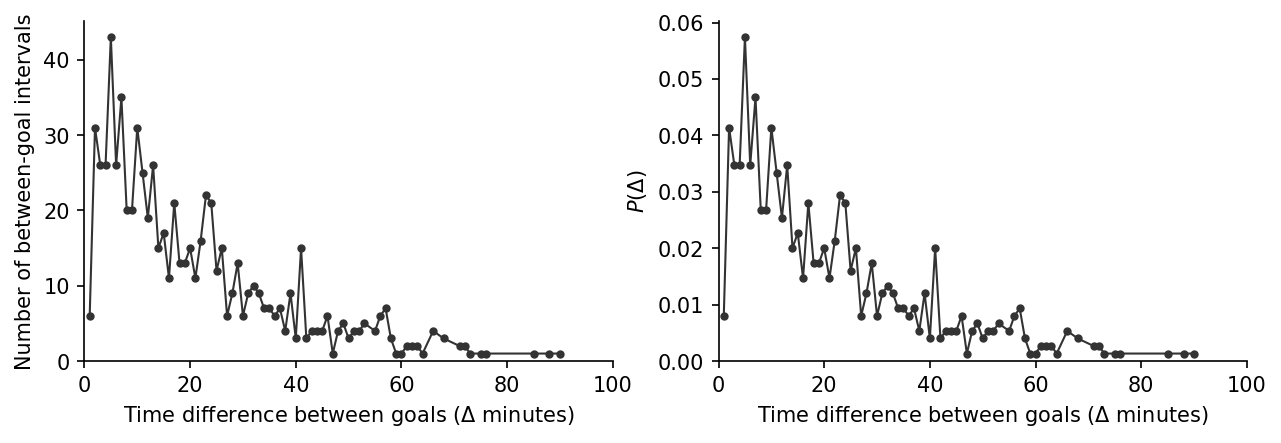

In [49]:
fig, ax = plt.subplots(1,2,figsize=(10,3),dpi=150)

ax[0].plot(counts.index, counts.values, color='0.2', marker='.', lw=1)
ax[0].set_ylabel('Number of between-goal intervals')
ax[0].set_xlabel(r'Time difference between goals ($\Delta$ minutes)')
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0)
ax[0].spines[['right', 'top']].set_visible(False)

ax[1].plot(probs.index, probs.values, color='0.2', marker='.', lw=1)
ax[1].set_ylabel(r'$P(\Delta)$')
ax[1].set_xlabel(r'Time difference between goals ($\Delta$ minutes)')
ax[1].set_xlim(0, 100)
ax[1].set_ylim(0)
ax[1].spines[['right', 'top']].set_visible(False)


plt.show()

_________
## We also have data from *six* leagues, over 10 seasons each. Does the pattern still hold?

`data/shot_times_six_leagues.csv`

We'll do the same thing as above, but now we can compare leagues:

- does the waiting-time distribution look similar?
- do leagues differ mainly in the *rate* (slope) or the *shape*?


In [50]:
df_all = pd.read_csv('data/shot_times_six_leagues.csv')
df_all = df_all.loc[df_all['minute'] < 120].copy()

df_all['total_goals'] = df_all['home_goals'] + df_all['away_goals']
df_all_goals = df_all.loc[
    (df_all['total_goals'] > 1) &
    (df_all['result'].isin(['Goal','OwnGoal']))
].copy()

# define a match key that is unique across the dataset
match_cols = ['league','season','match_id']

# sort before diff
df_all_goals = df_all_goals.sort_values(match_cols + ['minute'])

# between-goal intervals
df_all_goals['goal_timediff'] = df_all_goals.groupby(match_cols)['minute'].diff()

dfg = df_all_goals.loc[df_all_goals['goal_timediff'].notna()].copy()
dfg['goal_timediff'] = dfg['goal_timediff'].astype(int)
dfg = dfg.loc[dfg['goal_timediff'] >= 1].copy()

counts_all = dfg['goal_timediff'].value_counts().sort_index()
probs_all = counts_all / counts_all.sum()


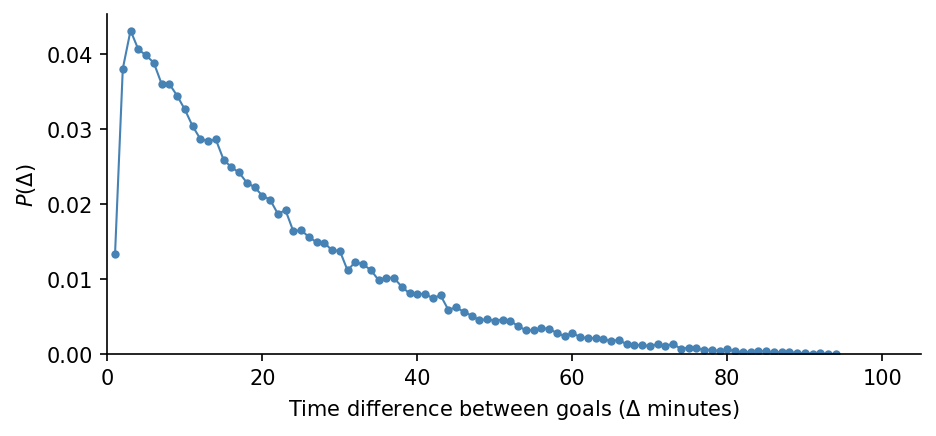

In [51]:
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=150)

ax.plot(probs_all.index, probs_all.values, color='steelblue', marker='.', lw=1)
ax.set_xlabel(r'Time difference between goals ($\Delta$ minutes)')
ax.set_ylabel(r'$P(\Delta)$')
ax.set_xlim(0, 105)
ax.set_ylim(0)
ax.spines[['right', 'top']].set_visible(False)

# plt.savefig('images/pngs/timediff_goals.png',dpi=425,bbox_inches='tight')
# plt.savefig('images/pdfs/timediff_goals.pdf',dpi=425,bbox_inches='tight')

plt.show()

This phenomenon is explored in: Ayana, G., Ehlert, A., Ehlert, J., Santagata, L., Torricelli, M., & Klein, B. (2025). Temporal dynamics of goal scoring in soccer (Preprint). arXiv. https://doi.org/10.48550/arXiv.2501.18606

---

## Minimal model of goal-scoring dynamics: would we expect this?

A super-minimal discrete-time model:

- For each minute $t$, a goal occurs with probability $p(t)$.
- If $p(t)$ were constant, waiting times would be geometric (memoryless).

We'll compare:
1. empirical waiting-time distribution  
2. simulated waiting-time distribution using an estimated time-varying $p(t)$  
3. baseline simulated waiting-time distribution using a constant $p$

**Note:** This ignores censoring (matches with zero goals) and treats minutes as independent.



### Comparison: empirical vs simulated waiting-time distributions
- compute the empirical distribution
- estimate a simple time-varying per-minute goal probability
- simulate matches from that model
- compare the simulated waiting-time distribution to the empirical one


In [52]:
# We'll use the six-league file for this comparison

match_cols = ['league', 'season', 'match_id']

# keep goal events only
df_all_goals = df_all.loc[df_all['result'].isin(['Goal','OwnGoal'])].copy()

# sort before diff (critical)
df_all_goals = df_all_goals.sort_values(match_cols + ['minute'])

# between-goal waiting times
df_all_goals['goal_timediff'] = df_all_goals.groupby(match_cols)['minute'].diff()

# keep only between-goal (drop first goal in each match)
dfg = df_all_goals.loc[df_all_goals['goal_timediff'].notna()].copy()
dfg['goal_timediff'] = dfg['goal_timediff'].astype(int)

# basic cleanup
dfg = dfg.loc[dfg['goal_timediff'] >= 1].copy()

waits_emp = dfg['goal_timediff'].values.astype(int)

print('Number of between-goal waiting times (empirical):', len(waits_emp))
print('Mean between-goal waiting time (empirical):', waits_emp.mean())

Number of between-goal waiting times (empirical): 40169
Mean between-goal waiting time (empirical): 20.161268639996017


### Step 1: Empirical waiting-time distribution

We've already computed the empirical PMF (probability mass function) for waiting times $\Delta$ in minutes.


In [53]:
max_k = 105
k = np.arange(1, max_k + 1)

emp_counts = pd.Series(waits_emp).value_counts().sort_index()
emp_pmf = emp_counts.reindex(k, fill_value=0).values.astype(float)
emp_pmf = emp_pmf / emp_pmf.sum()

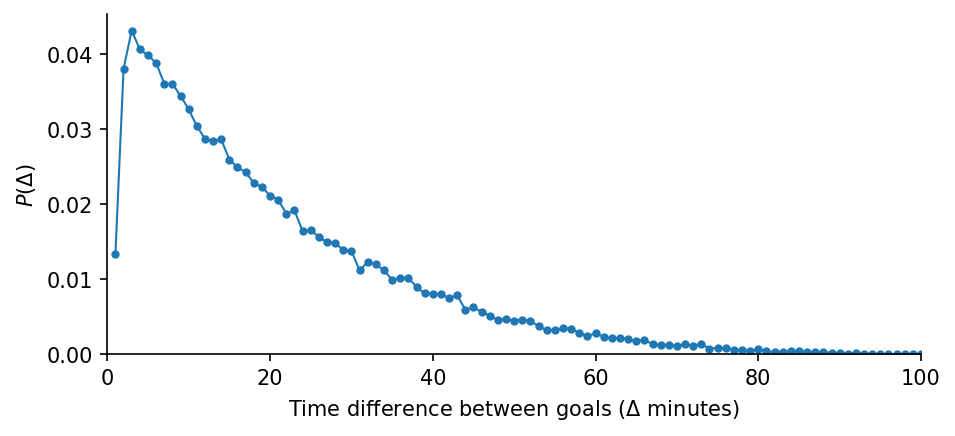

In [54]:
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=150)

ax.plot(k, emp_pmf, marker='.', lw=1)
ax.set_xlabel(r'Time difference between goals ($\Delta$ minutes)')
ax.set_ylabel(r'$P(\Delta)$')
ax.set_xlim(0, 100)
ax.set_ylim(0)
ax.spines[['right','top']].set_visible(False)

plt.show()

### Step 2: Estimate a per-minute goal probability curve, $p(t)$

A super-minimal model: in each minute \(t\), a goal happens with probability $p(t)$.

We'll estimate $p(t)$ from the data as:

$$
p(t) \approx \frac{\#\text{goals occurring in minute } t}{\#\text{matches}}
$$

This is crude, but good enough for a first comparison.

In [55]:
# number of matches in this dataset
n_matches = df_all[match_cols].drop_duplicates().shape[0]

# goals per minute
goals_by_min = df_all_goals['minute'].astype(int).value_counts().sort_index()

# define a time window (0..94) to roughly include stoppage time but stay simple
T = 100
minutes = np.arange(0, T)

p_t = np.zeros(T, dtype=float)
for t in minutes:
    p_t[t] = goals_by_min.get(t, 0) / n_matches

# quick sanity checks
print('n_matches:', n_matches)
print('mean p(t) over 0..94:', p_t.mean())
print('implied mean goals per match (sum p(t)):', p_t.sum())

n_matches: 22190
mean p(t) over 0..94: 0.02739657503379901
implied mean goals per match (sum p(t)): 2.739657503379901


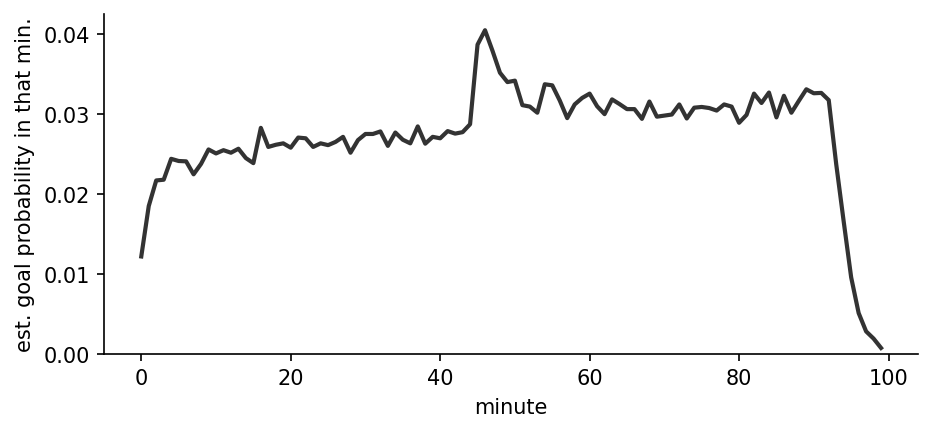

In [56]:
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=150)

ax.plot(minutes, pd.Series(p_t).rolling(window=1, center=True).mean(), lw=2, color='.2')
ax.set_xlabel('minute')
ax.set_ylabel('est. goal probability in that min.')
ax.set_ylim(0)
ax.spines[['right','top']].set_visible(False)

plt.show()

### Step 3: Simulate matches from the time-varying model

For each simulated match:
- iterate minutes $t=0,1,\dots,T-1$
- flip a Bernoulli coin with probability $p(t)$
- record goal times
- compute between-goal waiting times


In [57]:
np.random.seed(0)

n_games = n_matches  # match the dataset size (keeps the comparison fair)

waits_sim_tv = []  # time-varying p(t)
for game in range(n_games):
    goal_times = []
    for t in range(T):
        if np.random.rand() < p_t[t]:
            goal_times.append(t)

    # between-goal only
    if len(goal_times) > 1:
        waits_sim_tv.extend(np.diff(goal_times))

waits_sim_tv = np.array(waits_sim_tv, dtype=int)
waits_sim_tv = waits_sim_tv[waits_sim_tv >= 1]

print('Number of between-goal waiting times (sim, time-varying):', len(waits_sim_tv))
print('Mean between-goal waiting time (sim, time-varying):', waits_sim_tv.mean())


Number of between-goal waiting times (sim, time-varying): 40069
Mean between-goal waiting time (sim, time-varying): 19.91716788539769


### Step 4: Baseline constant-$p$ model

A stricter null model assumes the goal probability is constant across minutes: $p(t)=p_0$ for all $t$.

We'll take $p_0$ as the average of $p(t)$.


In [58]:
np.random.seed(0)

p0 = p_t.mean()

waits_sim_const = []
for game in range(n_games):
    goal_times = []
    for t in range(T):
        if np.random.rand() < p0:
            goal_times.append(t)

    if len(goal_times) > 1:
        waits_sim_const.extend(np.diff(goal_times))

waits_sim_const = np.array(waits_sim_const, dtype=int)
waits_sim_const = waits_sim_const[waits_sim_const >= 1]

print('Mean between-goal waiting time (sim, constant p):', waits_sim_const.mean())


Mean between-goal waiting time (sim, constant p): 21.611842269560224


### Step 5: Compare distributions on the same support

We overlay:
- empirical PMF  
- simulated PMF with time-varying $p(t)$  
- simulated PMF with constant $p_0$


In [59]:
def pmf_on_support(samples, support):
    s = pd.Series(samples).value_counts().sort_index()
    pmf = s.reindex(support, fill_value=0).values.astype(float)
    if pmf.sum() > 0:
        pmf = pmf / pmf.sum()
    return pmf

sim_tv_pmf = pmf_on_support(waits_sim_tv, k)
sim_const_pmf = pmf_on_support(waits_sim_const, k)

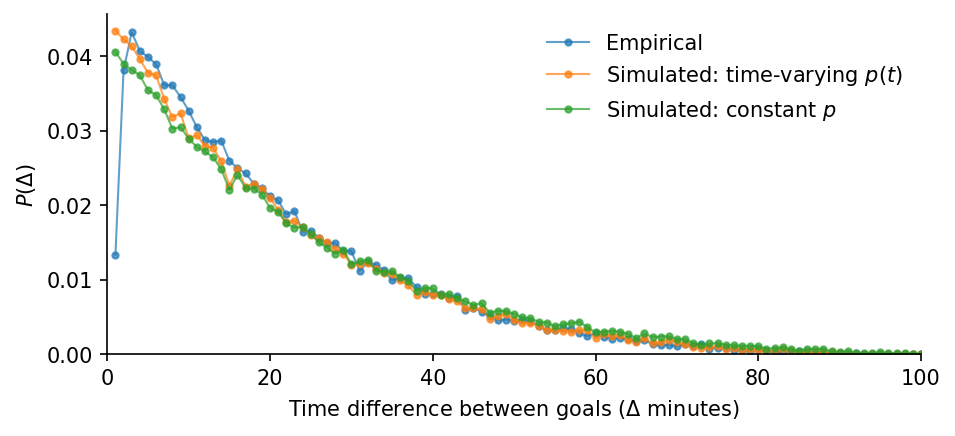

In [60]:
fig, ax = plt.subplots(1,1,figsize=(7,3),dpi=150)

ax.plot(k, emp_pmf, marker='.', lw=1, label='Empirical', alpha=0.7)
ax.plot(k, sim_tv_pmf, marker='.', lw=1, label='Simulated: time-varying $p(t)$', alpha=0.7)
ax.plot(k, sim_const_pmf, marker='.', lw=1, label='Simulated: constant $p$', alpha=0.7)

ax.set_xlabel(r'Time difference between goals ($\Delta$ minutes)')
ax.set_ylabel(r'$P(\Delta)$')
ax.set_xlim(0, 100)
ax.set_ylim(0)
ax.legend(framealpha=0.0)
ax.spines[['right','top']].set_visible(False)

plt.show()

### Step 6: One-number summaries (optional, but helpful)

Quick ways to quantify mismatch.

A simple choice is the $L_1$ distance between PMFs:

$$
\|p-q\|_1 = \sum_k |p(k) - q(k)|
$$

Smaller means "closer" (on that support).

In [61]:
# L1 distance between PMFs (bigger = worse fit)
l1_tv = np.abs(emp_pmf - sim_tv_pmf).sum()
l1_const = np.abs(emp_pmf - sim_const_pmf).sum()

print('L1(empirical, time-varying) =', round(l1_tv, 4))
print('L1(empirical, constant)     =', round(l1_const, 4))

# means (also helpful)
print('Empirical mean Δ:', round(waits_emp.mean(), 3))
print('Sim (time-varying) mean Δ:', round(waits_sim_tv.mean(), 3))
print('Sim (constant) mean Δ:', round(waits_sim_const.mean(), 3))


L1(empirical, time-varying) = 0.0903
L1(empirical, constant)     = 0.1319
Empirical mean Δ: 20.161
Sim (time-varying) mean Δ: 19.917
Sim (constant) mean Δ: 21.612


---

## Model critique (what assumptions did we make?)

Our baseline models (Poisson / geometric / exponential and variants) rely on strong assumptions:

1. **Stationarity:** the event rate is constant in time (or depends only on minute $t$)  
2. **Independence:** goals don't change the process generating future goals  
3. **Homogeneity:** all matches (and teams) share the same parameters  

Sports violations are the interesting part:
- tactics + game state create time-varying rates
- teams differ (mixtures of "open" and "closed" games)
- a goal can change behavior immediately (momentum, substitutions, time-wasting)
- red cards, fatigue, and stoppage time create nonstationarity

The baseline is still valuable because it gives us a language for saying:  
**"Here is what we'd expect under a simple null. Now here's what the data do."**


__________
## Next time...
Regression Pt. 1 — Moneyball Replication `class_05_regression_01_moneyball.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/jkbren/cnet5442_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5442-spring26
2. APS News (2009): https://www.aps.org/apsnews/2009/07/pascal-letters-fermat-points
3. MIT OpenCourseWare 6.041: *Probabilistic Systems Analysis and Applied Probability*
4. MIT OpenCourseWare 18.440: *Probability and Random Variables*
5. Hacking, I. (1975). *The Emergence of Probability*. Cambridge University Press.
6. Shannon, C. E. (1948). *A Mathematical Theory of Communication*. Bell System Technical Journal. https://doi.org/10.1002/j.1538-7305.1948.tb01338.x
7. Kelly, J. L. (1956). *A New Interpretation of Information Rate*. Bell System Technical Journal. https://doi.org/10.1002/j.1538-7305.1956.tb03809.x  
8. Maher, M. J. (1982). *Modelling Association Football Scores*. Statistica Neerlandica. https://doi.org/10.1111/j.1467-9574.1982.tb00782.x  
9. Dixon, M. J., & Coles, S. G. (1997). *Modelling Association Football Scores and Inefficiencies in the Football Betting Market*. Journal of the Royal Statistical Society: Series C (Applied Statistics). https://doi.org/10.1111/1467-9876.00065  
10. Ayana, G., Ehlert, A., Ehlert, J., Santagata, L., Torricelli, M., & Klein, B. (2025). *Temporal dynamics of goal scoring in soccer*. arXiv:2501.18606. https://doi.org/10.48550/arXiv.2501.18606  
11. NumPy, Pandas, Matplotlib documentation


---

## Supplemental Information: Weak LLN (a short proof sketch)

Assume:
- $X_1,\dots,X_n$ are independent and identically distributed (i.i.d.)
- $E[X_i]=\mu$
- $\mathrm{Var}(X_i)=\sigma^2 < \infty$

Let $\bar X_n = \frac{1}{n}\sum_{i=1}^n X_i$.

### Step 1: mean and variance of the average
Using linearity of expectation and independence:

$$
E[\bar X_n]=\mu, \qquad \mathrm{Var}(\bar X_n)=\frac{\sigma^2}{n}.
$$

### Step 2: Chebyshev’s inequality
For any random variable $Y$ with finite variance and any $\varepsilon>0$:

$$
P(|Y-E[Y]|\ge \varepsilon) \le \frac{\mathrm{Var}(Y)}{\varepsilon^2}.
$$

Apply this with $Y=\bar X_n$:

$$
P(|\bar X_n-\mu|\ge \varepsilon) \le \frac{\sigma^2}{n\varepsilon^2}.
$$

As $n\to\infty$, the right-hand side goes to 0, so the probability that $\bar X_n$ is far from $\mu$ goes to 0.

That's the **Weak Law of Large Numbers**.

Below, we'll compare Chebyshev’s bound to an empirical simulation for a Bernoulli random variable.


In [62]:
# Chebyshev bound vs empirical probability (for Bernoulli)
p_true = 0.3
mu = p_true
sigma2 = p_true * (1 - p_true)

eps = 0.05
ns = np.array([10, 20, 50, 100, 200, 500, 1000, 2000])

M = 30_000  # number of repeated experiments per n

empirical = []
bound = []

for n in ns:
    means = rng.binomial(n=1, p=p_true, size=(M, n)).mean(axis=1)
    empirical.append(np.mean(np.abs(means - mu) >= eps))
    bound.append(sigma2 / (n * eps**2))

empirical = np.array(empirical)
bound = np.array(bound)

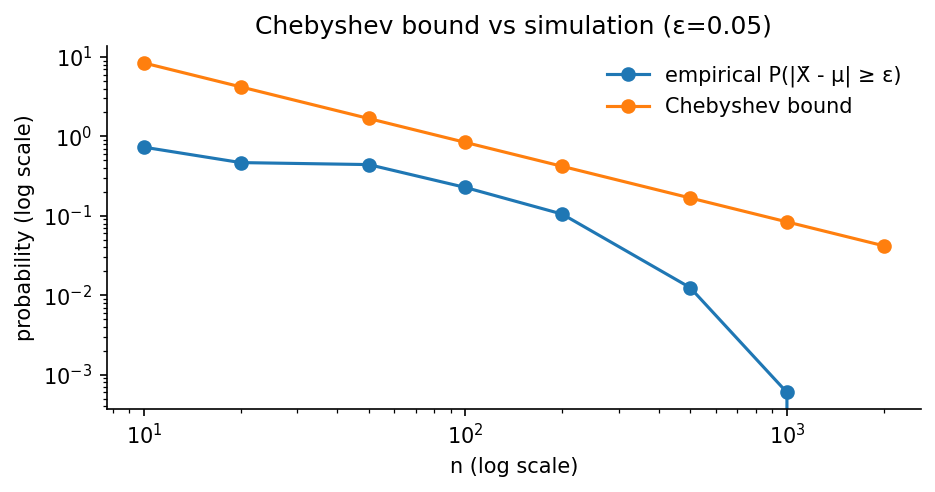

In [63]:
fig, ax = plt.subplots(figsize=(7, 3.2), dpi=150)
ax.plot(ns, empirical, marker="o", lw=1.5, label="empirical P(|X̄ - μ| ≥ ε)")
ax.plot(ns, bound, marker="o", lw=1.5, label="Chebyshev bound")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("n (log scale)")
ax.set_ylabel("probability (log scale)")
ax.set_title(f"Chebyshev bound vs simulation (ε={eps})")
ax.legend(framealpha=0.0)
ax.spines[["right", "top"]].set_visible(False)
plt.show()


---

## Supplemental Information: Odds, implied probabilities, and vig

This section connects betting-style odds to probability language.

In probability terms, a sportsbook is posting a probability model **plus a fee**.
That fee is what allows the book to make money (on average) even if the posted odds reflect the crowd’s true probabilities reasonably well.


### 1) Fair odds and implied probability

For an outcome with true probability $p$:

- **Fair decimal odds** (no margin) are:

$$
d = \frac{1}{p}
$$

- Conversely, the **implied probability** from decimal odds $d$ is:

$$
\hat p = \frac{1}{d}
$$

If a market were "fair," then the implied probabilities across all mutually exclusive outcomes would sum to 1.


### 2) Common odds formats (and conversions)

We'll cover:
- **Decimal odds** (common in Europe): $d \ge 1$  
- **Fractional odds** (UK style): $a/b$  
- **American odds** (moneyline): $+A$ or $-A$

We'll implement conversion functions and show examples.



### 3) What is vig?

**Vig** (short for **vigorish**, also called the **juice**) is the bookmaker’s built-in commission.

Intuition:

- In a fair world, your "price" should be $1/p$.
- In a real book, you typically get *slightly worse* odds than $1/p$.
- That gap is how the house gets paid.

There are different ways people quantify vig. The most common *probability-language* summary is the **overround**.


### 4) Overround as a margin measure

For a market with outcomes $i=1..m$ and decimal odds $d_i$, define implied probabilities:

$$
\hat p_i = \frac{1}{d_i}
$$

Then define:

$$
S = \sum_{i=1}^m \hat p_i
$$

- If $S=1$, the book is "fair" (no margin).  
- If $S>1$, then the extra amount
  $$\text{overround} = S - 1$$
  is one common measure of the book’s margin.

You’ll also see people call $S$ the "book" or "implied probability sum."


#### Quick two-outcome example

A classic "even" 2-way market in the US is roughly **-110 / -110**.

- -110 corresponds to decimal odds $d \approx 1.909$  
- implied probability is $\hat p \approx 1/1.909 \approx 0.524$

If both sides are priced that way:

- $S \approx 0.524 + 0.524 = 1.048$  
- overround $\approx 0.048$ (about 4.8%)

That ~4.8% is a common *headline* vig/margin number for that market.

Important nuance: **overround is not exactly the same as realized profit**.  
Actual profit depends on how bettors split their money across outcomes. But overround is a convenient way to see the book’s built-in edge.



### 5) A simple "no-vig" estimate

A quick way to back out "fair-ish" probabilities from a set of posted odds is to renormalize:

$$
p_i^{\mathrm{nv}} = \frac{\hat p_i}{\sum_j \hat p_j}
$$

This produces probabilities that sum to 1 by construction.

Notes:

- This is not the only de-vigging method (there are others that assume different things about how the book sets prices).
- But it is a widely used first pass for analytics, especially when you want to compare a model’s probabilities to the market.

Below we implement these conversions and compute an overround + no-vig probabilities for a small example market.


In [64]:
def decimal_odds_to_implied_prob(decimal_odds):
    """Convert decimal odds to *raw* implied probability.

    Decimal odds (common in Europe) quote the **total payout including stake**.

    - If you stake 1 unit at decimal odds d and you win, you receive d units back.
    - If odds were perfectly fair (no bookmaker margin), then d = 1/p.

    So the corresponding implied probability is:

        p_hat = 1 / d

    Important: in real betting markets, the implied probabilities across all outcomes
    typically sum to > 1. That excess is the bookmaker margin (often summarized by
    the **overround**, and colloquially referred to as **vig** or **juice**).

    Parameters
    ----------
    decimal_odds:
        Decimal odds (must be >= 1). Can be a scalar or array.

    Returns
    -------
    float or np.ndarray
        Implied probability (same shape as input).
    """
    d = np.asarray(decimal_odds, dtype=float)
    if np.any(d < 1):
        raise ValueError("Decimal odds must be >= 1.")
    return 1.0 / d


def implied_prob_to_decimal_odds(p):
    """Convert probability to fair decimal odds (no margin).

    This is just the reciprocal:

        d = 1 / p

    Parameters
    ----------
    p:
        Probability (0 < p <= 1). Can be a scalar or array.

    Returns
    -------
    float or np.ndarray
        Fair decimal odds.
    """
    p = np.asarray(p, dtype=float)
    if np.any(p <= 0) or np.any(p > 1):
        raise ValueError("Probabilities must satisfy 0 < p <= 1.")
    return 1.0 / p


def fractional_to_decimal(a,b):
    """Convert fractional odds a/b to decimal odds.

    Fractional odds a/b mean:

    - profit a units for every b units staked

    Decimal odds include the stake back:

        d = 1 + a/b

    Example
    -------
    2/1 -> 3.0

    Parameters
    ----------
    a:
        Numerator (profit units). Must be nonnegative.
    b:
        Denominator (stake units). Must be positive.

    Returns
    -------
    float
        Decimal odds.
    """
    if b <= 0:
        raise ValueError("Denominator b must be positive.")
    if a < 0:
        raise ValueError("Numerator a must be nonnegative.")
    return 1.0 + (a / b)


def american_to_implied_prob(american):
    """Convert American odds (moneyline) to implied probability.

    Conventions:
    - Positive odds +A: risk 100 to win A  -> implied p = 100 / (A + 100)
    - Negative odds -A: risk A to win 100  -> implied p = A / (A + 100)

    Here A is the absolute value.

    Parameters
    ----------
    american:
        American odds (e.g., +200, -150). Cannot be 0.

    Returns
    -------
    float
        Implied probability.
    """
    if american == 0:
        raise ValueError("American odds cannot be 0.")

    a = float(american)
    if a > 0:
        return 100.0 / (a + 100.0)
    else:
        a = abs(a)
        return a / (a + 100.0)


def market_overround_from_decimal(decimal_odds):
    """Compute the overround (a common bookmaker margin measure) from decimal odds.

    For a market with outcomes i=1..m quoted in decimal odds d_i, the implied probabilities are:

        p_hat_i = 1 / d_i

    The implied probability sum is S = sum_i p_hat_i. Then:

        overround = S - 1

    Interpretation:
    - overround = 0 means the odds are perfectly fair (no margin)
    - overround > 0 means the market is priced with a built-in edge

    Parameters
    ----------
    decimal_odds:
        Iterable of decimal odds for each mutually exclusive outcome.

    Returns
    -------
    float
        Overround value (e.g., 0.05 means ~5%).
    """
    implied = decimal_odds_to_implied_prob(np.asarray(decimal_odds, dtype=float))
    return float(implied.sum() - 1.0)


def remove_vig_by_normalization(decimal_odds):
    """Compute a simple 'no-vig' probability vector by renormalizing implied probabilities.

    Given odds d_i, compute p_hat_i = 1/d_i and then normalize:

        p_i^nv = p_hat_i / sum_j p_hat_j

    This forces the probabilities to sum to 1 and is a common quick-and-dirty
    way to remove the bookmaker's margin (vig/overround) for analytics.

    Caveat:
    - This is not the only de-vigging method.
    - Different assumptions about how the book sets prices lead to different no-vig estimates.

    Parameters
    ----------
    decimal_odds:
        Iterable of decimal odds for each mutually exclusive outcome.

    Returns
    -------
    np.ndarray
        No-vig probabilities that sum to 1.
    """
    implied = decimal_odds_to_implied_prob(np.asarray(decimal_odds, dtype=float))
    total = implied.sum()
    if total <= 0:
        raise ValueError("Sum of implied probabilities must be positive.")
    return implied / total


In [65]:
# Example: a 3-way soccer market (Home / Draw / Away) quoted in decimal odds
market = {
    "Home": 2.20,
    "Draw": 3.40,
    "Away": 3.60,
}

outcomes = list(market.keys())
odds = np.array(list(market.values()), dtype=float)

implied = decimal_odds_to_implied_prob(odds)
overround = market_overround_from_decimal(odds)
no_vig = remove_vig_by_normalization(odds)

summary = pd.DataFrame(
    {
        "outcome": outcomes,
        "decimal_odds": odds,
        "implied_prob": implied,
        "no_vig_prob": no_vig,
        "no_vig_decimal_odds": implied_prob_to_decimal_odds(no_vig),
    }
)

summary


,outcome,decimal_odds,implied_prob,no_vig_prob,no_vig_decimal_odds
0,Home,2.2,0.454545,0.442836,2.258170
1,Draw,3.4,0.294118,0.286541,3.489899
2,Away,3.6,0.277778,0.270622,3.695187


In [66]:
print("Sum implied probs:", implied.sum())
print("Overround:", overround, "(i.e.,", round(100 * overround, 2), "%)")
print("Sum no-vig probs:", no_vig.sum())


Sum implied probs: 1.0264408793820559
Overround: 0.02644087938205586 (i.e., 2.64 %)
Sum no-vig probs: 1.0


### Another quick vig example: the -110 / -110 line

In US-style betting, a very common two-outcome market is quoted as **-110 on both sides**.
You can think of this as a “nearly fair” coin flip market with a small fee embedded.

Below we compute:

- implied probabilities for each side
- the implied probability sum $S$
- the overround $S-1$
- normalized no-vig probabilities


In [67]:
# A standard 2-way market: -110 / -110
american_market = np.array([-110, -110], dtype=float)

implied_2way = np.array([american_to_implied_prob(a) for a in american_market])
S_2way = implied_2way.sum()
overround_2way = S_2way - 1.0
no_vig_2way = implied_2way / S_2way

pd.DataFrame(
    {
        "side": ["Side A", "Side B"],
        "american": american_market,
        "implied_prob": implied_2way,
        "no_vig_prob": no_vig_2way,
    }
)

,side,american,implied_prob,no_vig_prob
0,Side A,-110.0,0.52381,0.5
1,Side B,-110.0,0.52381,0.5
